In [1]:
import json
import pandas as pd
from pathlib import Path
from typing import Dict, Any

# 指定目录和 json 文件
data_dir = Path('.')
json_files = [
    'rebuttal_set_fl.json',
    'refactored_alpha_gfn_set_new_icml.json',
    'rebuttal_set_temp_old.json',
    'refactored_alpha_gfn_set_new_icml_fl0.json'
]

def flatten_dict(d: Dict[str, Any], parent_key: str = '', sep: str = '_') -> Dict[str, Any]:
    """递归展平嵌套字典"""
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

# 加载所有 json 文件并解析为 DataFrame
all_data = []

for file in json_files:
    file_path = data_dir / file
    with open(file_path, 'r') as f:
        data = json.load(f)

    # 每个 json 文件的顶层 key 是实验名称，value 是参数字典
    for exp_name, exp_params in data.items():
        flat_params = flatten_dict(exp_params)
        flat_params['experiment_name'] = exp_name  # 保存实验名称
        flat_params['source_file'] = file  # 保存来源文件
        all_data.append(flat_params)

# 转换为 DataFrame
df = pd.DataFrame(all_data)

print(f"✓ 加载完成！共 {len(df)} 行")
print(f"✓ 列数: {len(df.columns)}")
print(f"\n数据源: {json_files}")
print(f"\nDataFrame 形状: {df.shape}")
print(f"\n前几行:")
df.head()

✓ 加载完成！共 450 行
✓ 列数: 116

数据源: ['rebuttal_set_fl.json', 'refactored_alpha_gfn_set_new_icml.json', 'rebuttal_set_temp_old.json', 'refactored_alpha_gfn_set_new_icml_fl0.json']

DataFrame 形状: (450, 116)

前几行:


,_runtime,_step,_timestamp,action_dim,alpha,alpha_init,alpha_logit,alpha_lr,alpha_sched,alpha_train_first_steps,...,use_modified_reward,use_replay_buffer,wdb,experiment_name,source_file,ckpt_every,ckpt_save_history,ckpt_save_test_set,resume,wdb_group
0,205719.880689,200,1.763940e+09,80,0.503678,0.7,0.014711,0.001,hold_exp,False,...,False,False,True,ss(0)_ms(0)_md(on)_mdfr(0)_upb(1)_sz(medium)_m...,rebuttal_set_fl.json,NaN,NaN,NaN,NaN,NaN
1,19711.694562,200,1.763543e+09,30,0.501839,0.6,0.007356,0.001,hold_exp,False,...,False,False,True,ss(4)_ms(0)_md(on)_mdfr(0)_upb(1)_sz(small)_m(...,rebuttal_set_fl.json,NaN,NaN,NaN,NaN,NaN
2,27512.494409,200,1.763515e+09,30,0.494483,0.2,-0.022068,0.001,hold_exp,False,...,False,False,True,ss(4)_ms(0)_md(on)_mdfr(0)_upb(1)_sz(small)_m(...,rebuttal_set_fl.json,NaN,NaN,NaN,NaN,NaN
3,154038.657995,200,1.763714e+09,80,0.501839,0.6,0.007356,0.001,hold_exp,False,...,False,False,True,ss(0)_ms(0)_md(on)_mdfr(0)_upb(1)_sz(medium)_m...,rebuttal_set_fl.json,NaN,NaN,NaN,NaN,NaN
4,22856.400692,200,1.763469e+09,30,0.507356,0.9,0.029425,0.001,hold_exp,False,...,False,False,True,ss(4)_ms(0)_md(on)_mdfr(0)_upb(1)_sz(small)_m(...,rebuttal_set_fl.json,NaN,NaN,NaN,NaN,NaN


In [2]:
import re
import numpy as np

# 复制一份以免污染原始 df
df_all = df.copy()

# 解析实验名称中的参数
def parse_exp_name(exp_name: str) -> dict:
    params = {}
    ss_match = re.search(r'ss\((\d+)\)', exp_name)
    if ss_match:
        params['seed'] = int(ss_match.group(1))

    m_match = re.search(r'_m\(([^)]+)\)', exp_name)
    if m_match:
        params['method'] = m_match.group(1)

    # 提取size sz(xxx)
    sz_match = re.search(r'_sz\(([^)]+)\)', exp_name)
    if sz_match:
        params['size'] = sz_match.group(1)

    a_match = re.search(r'_a\(([^)]+)\)', exp_name)
    if a_match:
        try:
            params['alpha_init_from_name'] = float(a_match.group(1))
        except ValueError:
            params['alpha_init_from_name'] = np.nan

    return params

parsed_rows = []
for _, row in df_all.iterrows():
    name = row.get('experiment_name', '')
    parsed = parse_exp_name(name)
    method = parsed.get('method')
    
    # # 来自这个文件的method加上"fl-"前缀
    # source_file = row.get('source_file', '')
    # if source_file in ['refactored_alpha_gfn_set_new_icml.json']:
    #     if method:
    #         method = f"fl_{method}"
    
    parsed_rows.append({
        **row,
        'seed': parsed.get('seed'),
        'method': method,
        'size': parsed.get('size'),
        'alpha_init_name': parsed.get('alpha_init_from_name'),
        'alpha': row.get('alpha_init', row.get('alpha'))
    })

df_all = pd.DataFrame(parsed_rows)

# 过滤掉来自 rebuttal_set_fl.json 且 method 为 subtb_gfn 的数据
before_filter = len(df_all)
df_all = df_all[~((df_all['source_file'] == 'rebuttal_set_fl.json') & (df_all['method'] == 'subtb_gfn'))]
after_filter = len(df_all)
if before_filter > after_filter:
    print(f"✓ 已过滤掉 {before_filter - after_filter} 条数据（来自 rebuttal_set_fl.json 且 method=subtb_gfn）\n")

print(f"总实验数: {len(df_all)}")
print(f"Unique seeds: {sorted(df_all['seed'].dropna().unique())}")
print(f"Unique sizes: {sorted(df_all['size'].dropna().unique())}")
print(f"Unique alphas (from alpha_init): {sorted(df_all['alpha'].dropna().unique())}")
print(f"Unique objectives/methods: {sorted(df_all['method'].dropna().unique())}")
print("\n数据来源分布:")
print(df_all.groupby(['source_file', 'method', 'size']).size())

# 使用指定的评估指标
metrics = ['modes', 'mean_top_1000_R', 'mean_top_1000_similarity', 'spearman_corr_test']

# 检查哪些指标存在
available_metrics = [m for m in metrics if m in df_all.columns]
missing_metrics = [m for m in metrics if m not in df_all.columns]

if missing_metrics:
    print(f"⚠️ 缺失指标: {missing_metrics}")
    print(f"✓ 可用指标: {available_metrics}\n")
    metrics = available_metrics

objectives = sorted(df_all['method'].dropna().unique())
sizes = sorted(df_all['size'].dropna().unique())

print(f"\n{'=' * 80}")
print(f"找到 {len(objectives)} 个 objectives: {objectives}")
print(f"找到 {len(sizes)} 个 sizes: {sizes}")
print(f"{'=' * 80}")

# 收集绘图配置
fig_configs = []

for obj in objectives:
    for size in sizes:
        print(f"\n{'=' * 80}")
        print(f"Objective: {obj}, Size: {size}")
        print(f"{'=' * 80}")

        df_obj = df_all[(df_all['method'] == obj) & (df_all['size'] == size)].copy()
        if len(df_obj) == 0:
            print("无数据，跳过")
            continue

        print(f"  实验数: {len(df_obj)}")
        print(f"  来源文件: {df_obj['source_file'].unique()}")

        df_averaged = df_obj.groupby('alpha')[metrics].mean().reset_index()
        df_averaged = df_averaged.sort_values('alpha')

        print("\n按 seed 平均后的结果 (基于 alpha_init):")
        print(df_averaged.to_string(index=False))

        print("\n最优 Alpha 分析:")
        print(f"{'-' * 80}")
        for metric in metrics:
            if len(df_averaged) > 0 and not df_averaged[metric].isna().all():
                best_idx = df_averaged[metric].idxmax()
                best_alpha = df_averaged.loc[best_idx, 'alpha']
                best_value = df_averaged.loc[best_idx, metric]
                print(f"  {metric:30s} -> 最优 alpha_init: {best_alpha:.4f}, 最优值: {best_value:.6f}")

        plot_metrics = [m for m in metrics if not df_averaged[m].isna().all()]
        if plot_metrics:
            fig_configs.append({
                'method': obj,
                'size': size,
                'data': df_averaged,
                'metrics': plot_metrics
            })

✓ 已过滤掉 90 条数据（来自 rebuttal_set_fl.json 且 method=subtb_gfn）

总实验数: 360
Unique seeds: [0, 1, 2, 3, 4]
Unique sizes: ['large', 'medium', 'small']
Unique alphas (from alpha_init): [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
Unique objectives/methods: ['db_gfn', 'fl_db_gfn', 'fl_subtb_gfn', 'subtb_gfn', 'tb_gfn']

数据来源分布:
source_file                                 method        size  
rebuttal_set_fl.json                        fl_subtb_gfn  medium    45
                                                          small     45
rebuttal_set_temp_old.json                  db_gfn        large     10
                                                          medium    10
                                                          small     10
                                            fl_db_gfn     large     10
                                                          medium    10
                                                          small     10
                                            tb_


生成图表
✓ 已保存图表: side_product/set_analysis_db_gfn_large.png


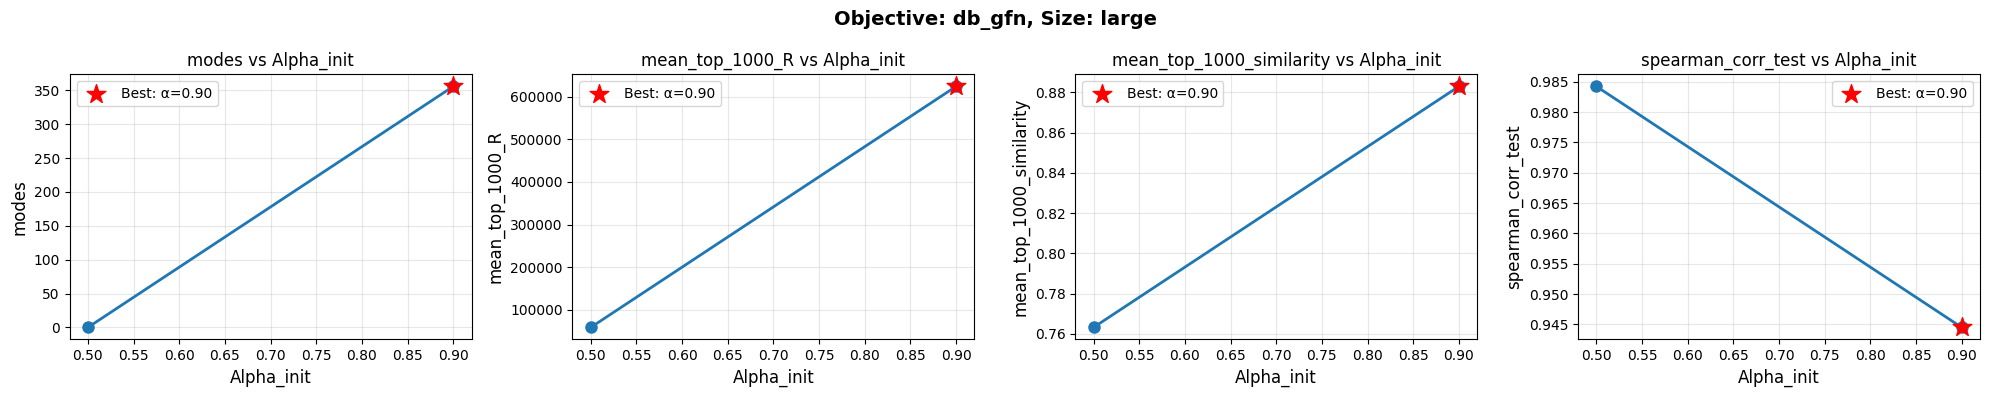

✓ 已保存图表: side_product/set_analysis_db_gfn_medium.png


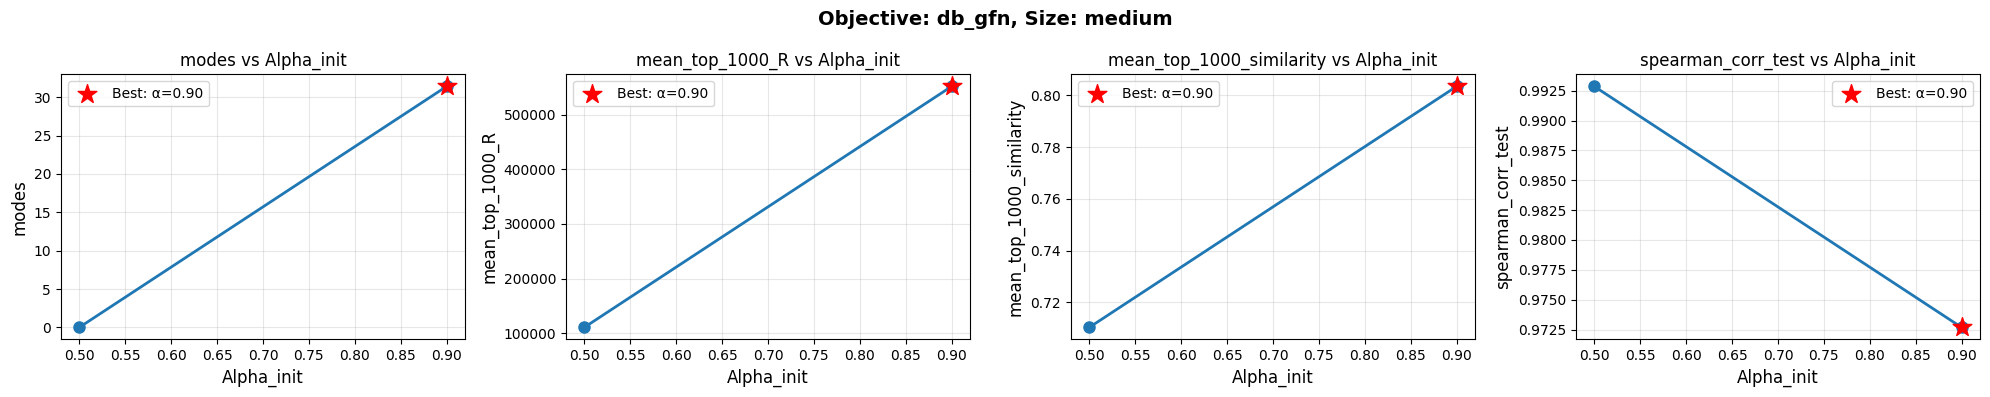

✓ 已保存图表: side_product/set_analysis_db_gfn_small.png


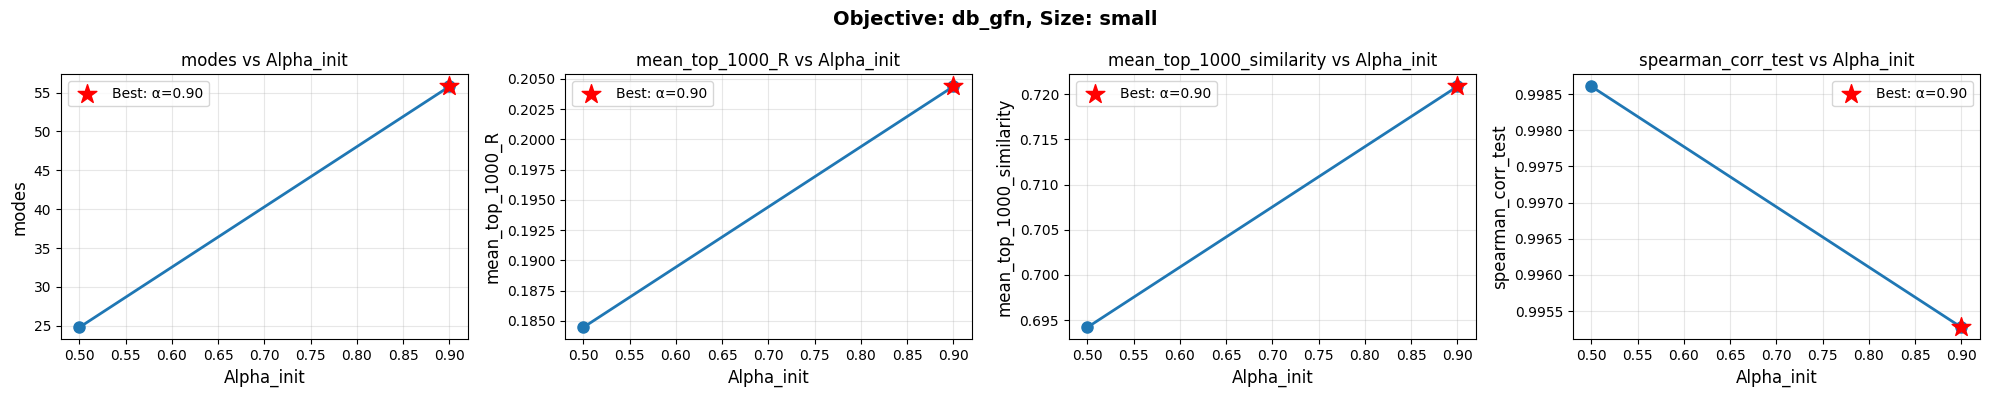

✓ 已保存图表: side_product/set_analysis_fl_db_gfn_large.png


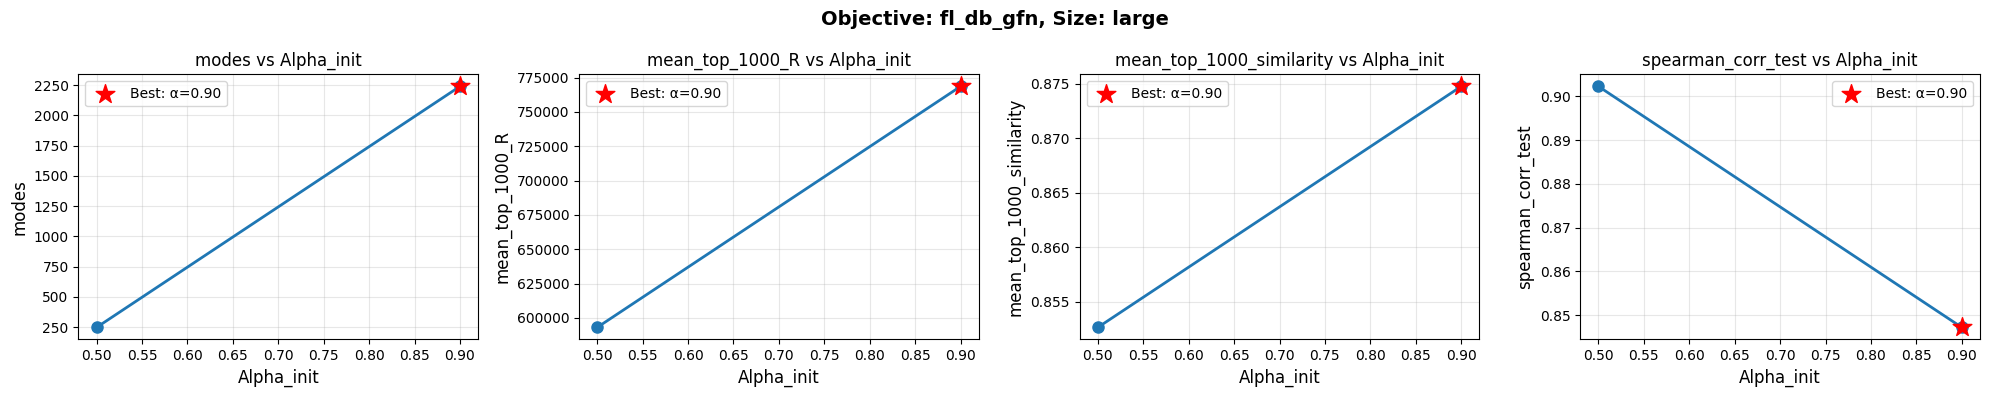

✓ 已保存图表: side_product/set_analysis_fl_db_gfn_medium.png


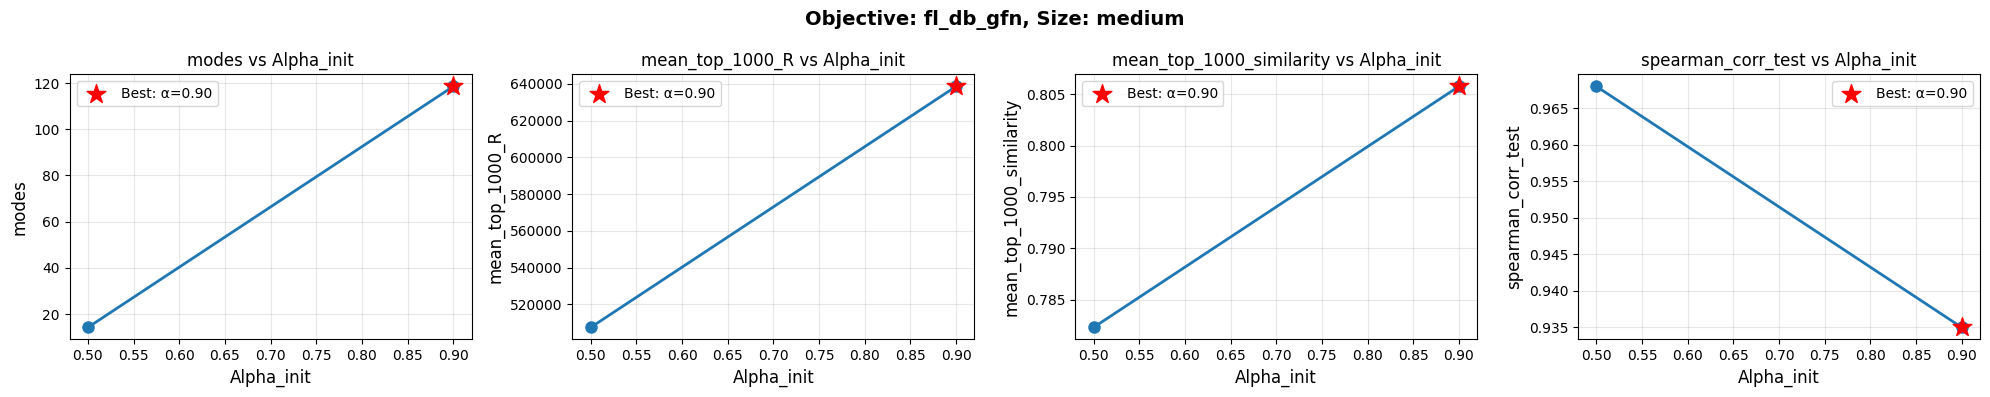

✓ 已保存图表: side_product/set_analysis_fl_db_gfn_small.png


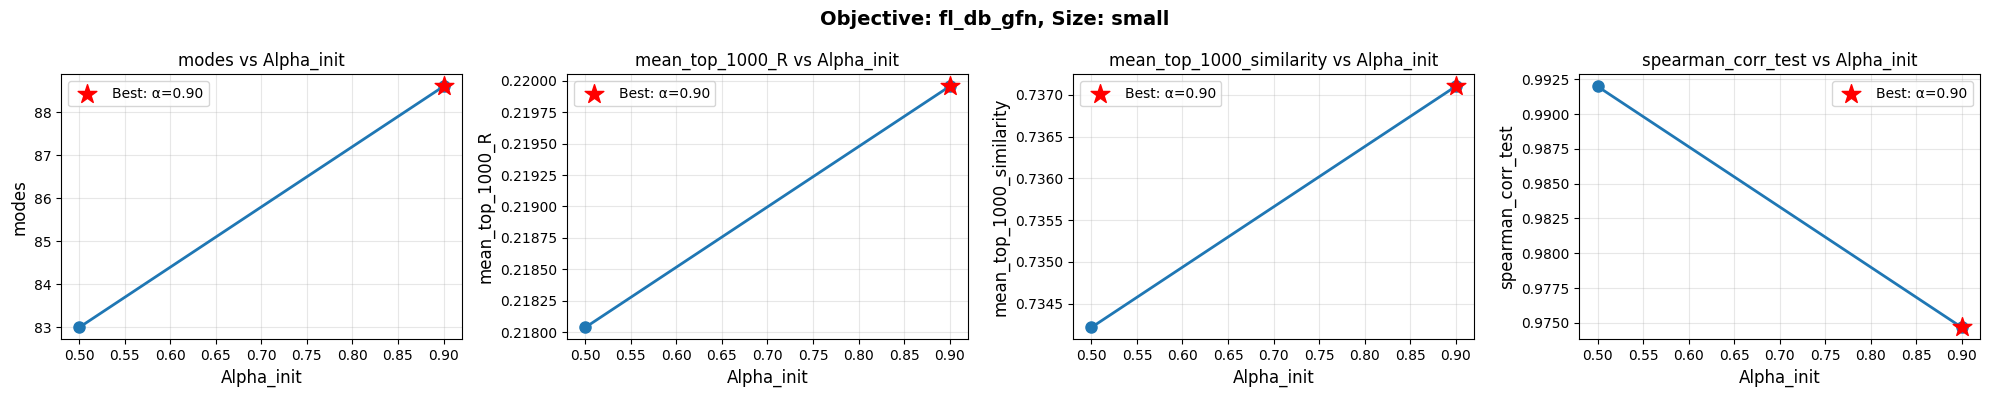

✓ 已保存图表: side_product/set_analysis_fl_subtb_gfn_large.png


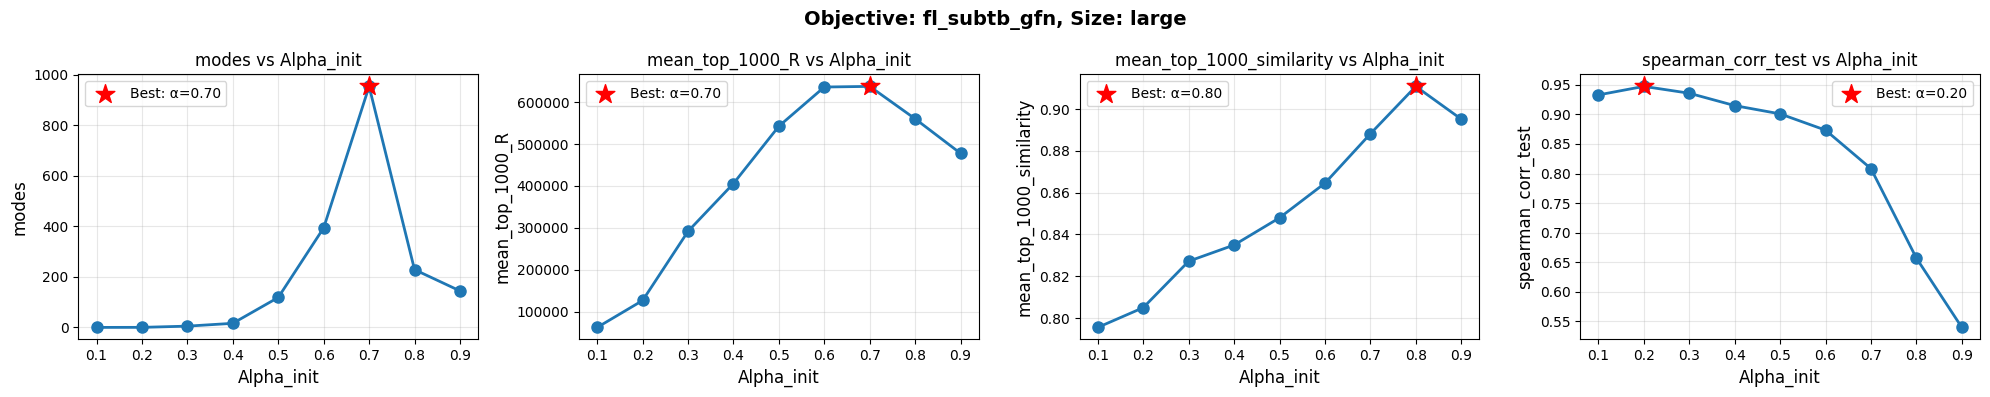

✓ 已保存图表: side_product/set_analysis_fl_subtb_gfn_medium.png


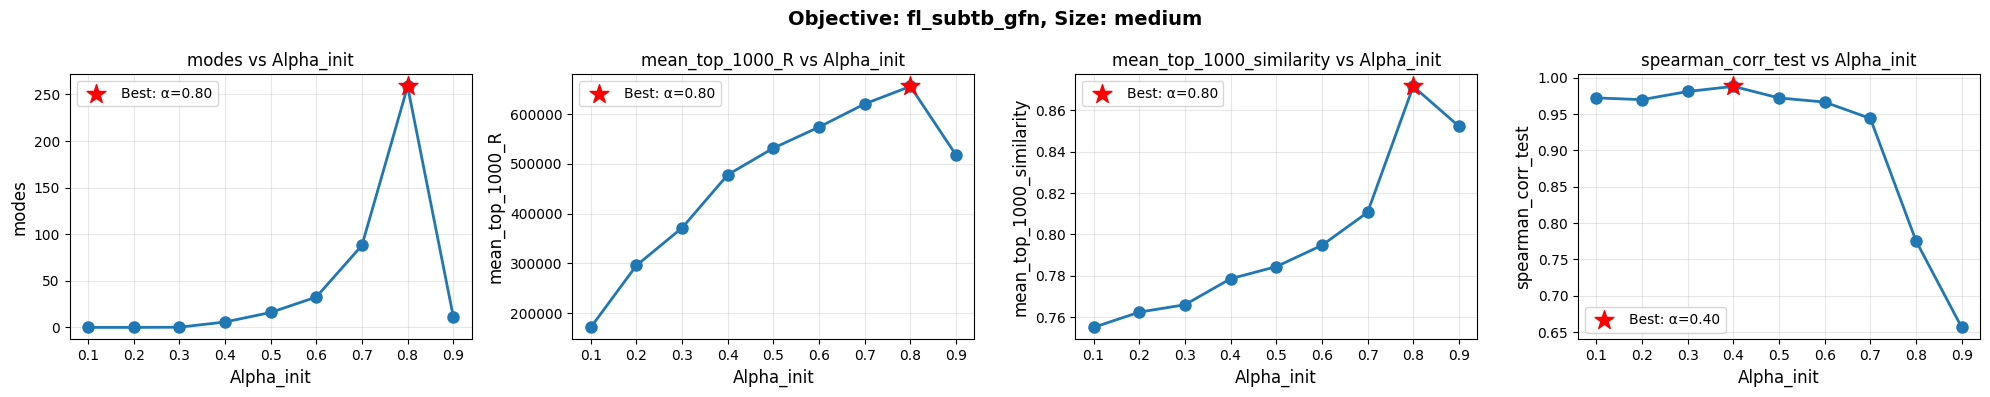

✓ 已保存图表: side_product/set_analysis_fl_subtb_gfn_small.png


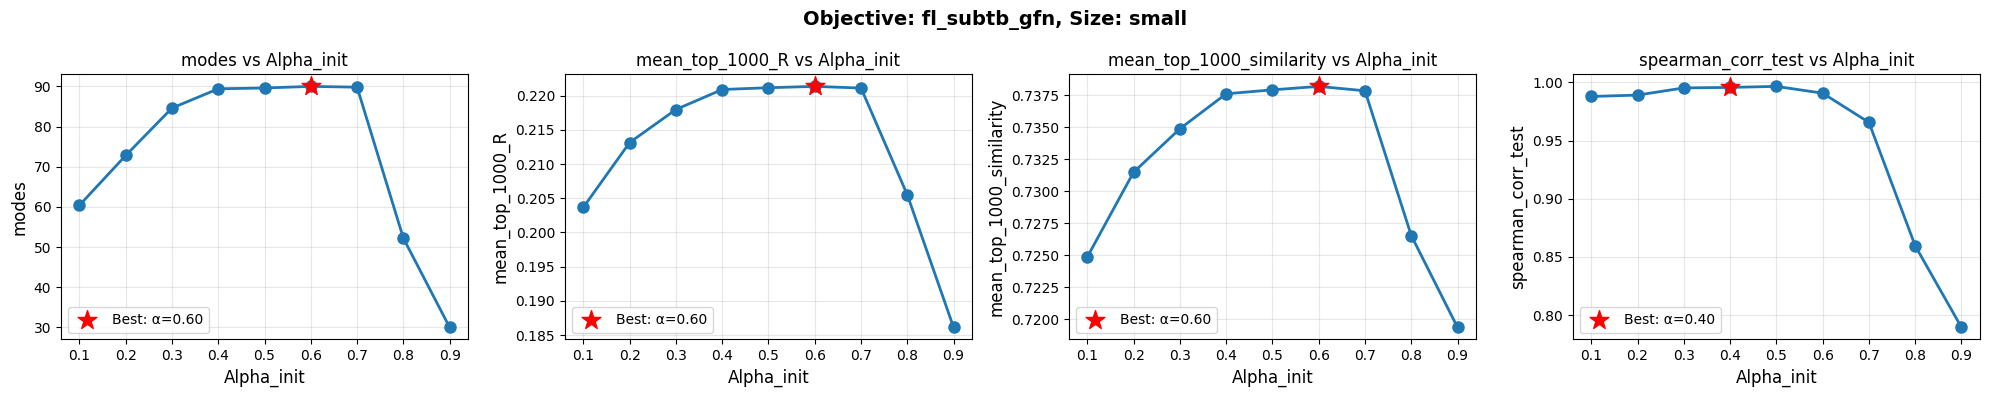

✓ 已保存图表: side_product/set_analysis_subtb_gfn_large.png


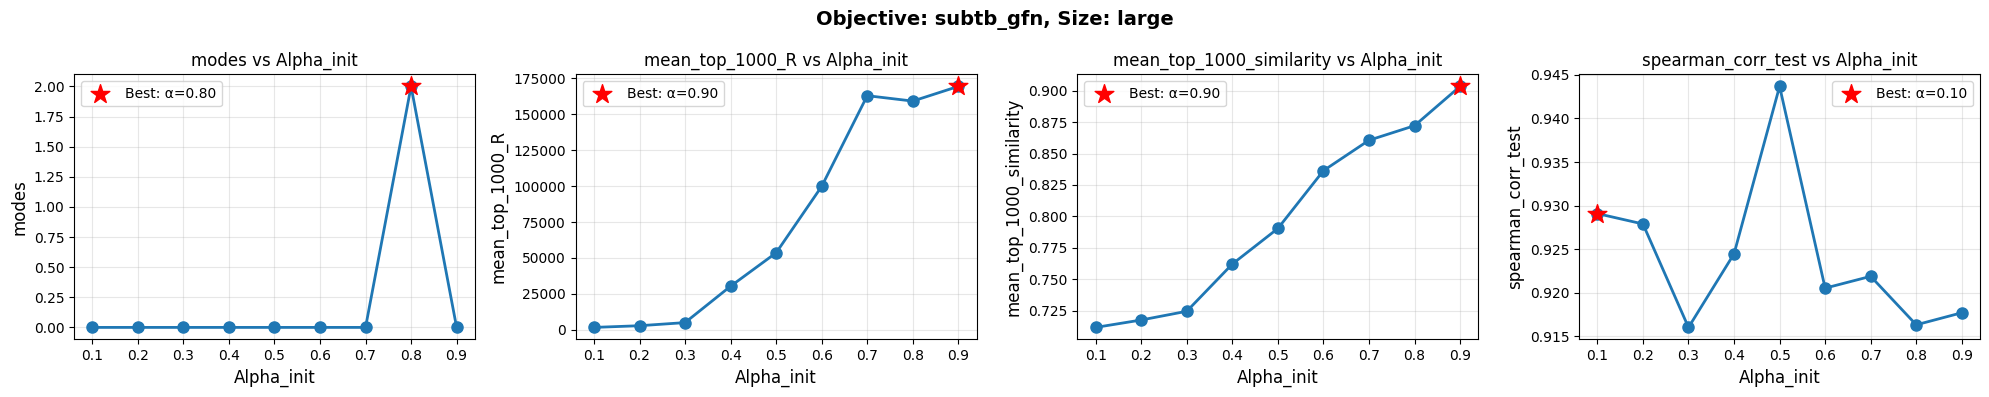

✓ 已保存图表: side_product/set_analysis_subtb_gfn_medium.png


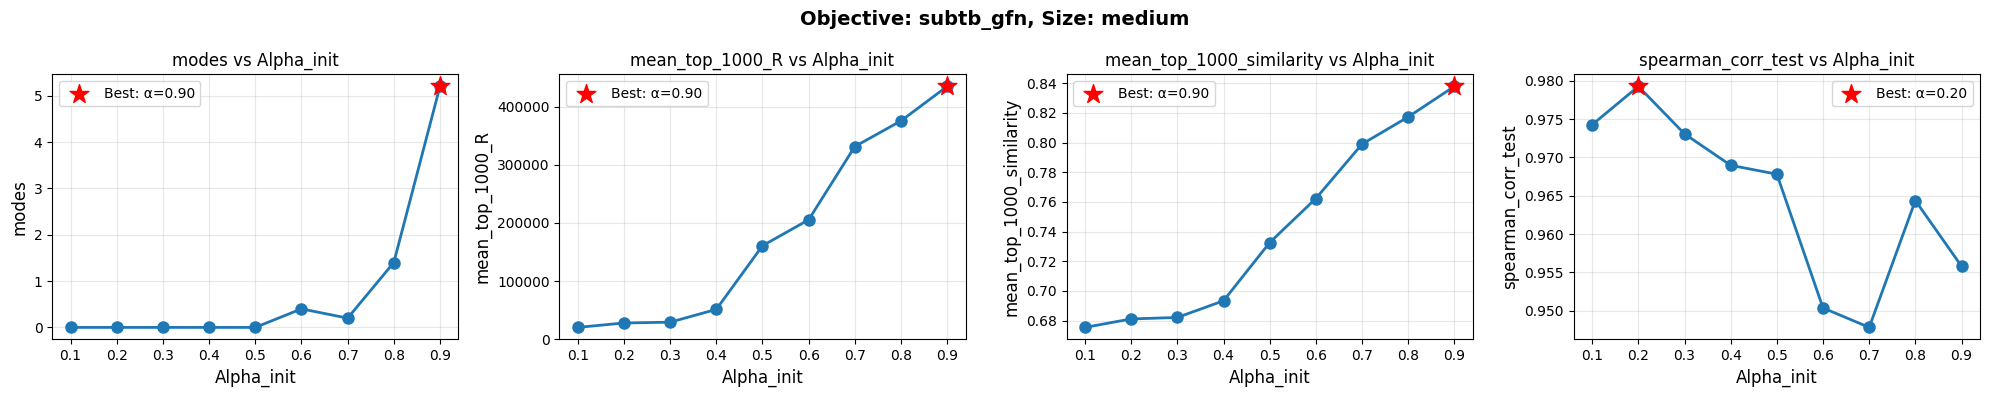

✓ 已保存图表: side_product/set_analysis_subtb_gfn_small.png


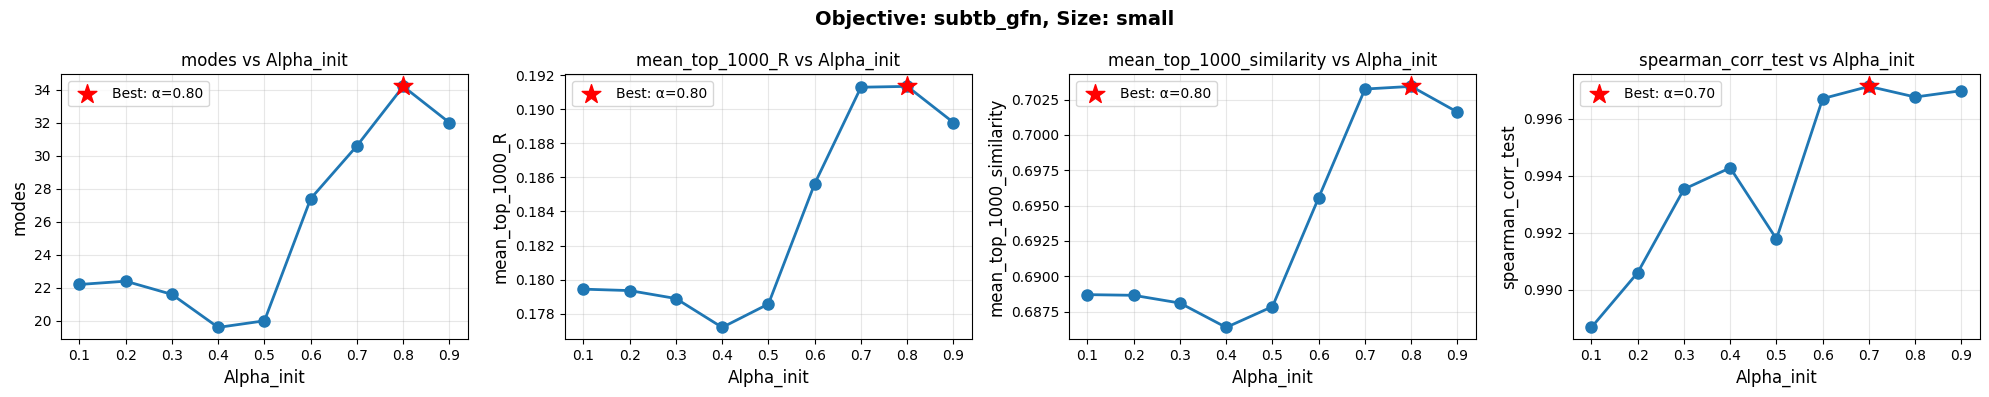

✓ 已保存图表: side_product/set_analysis_tb_gfn_large.png


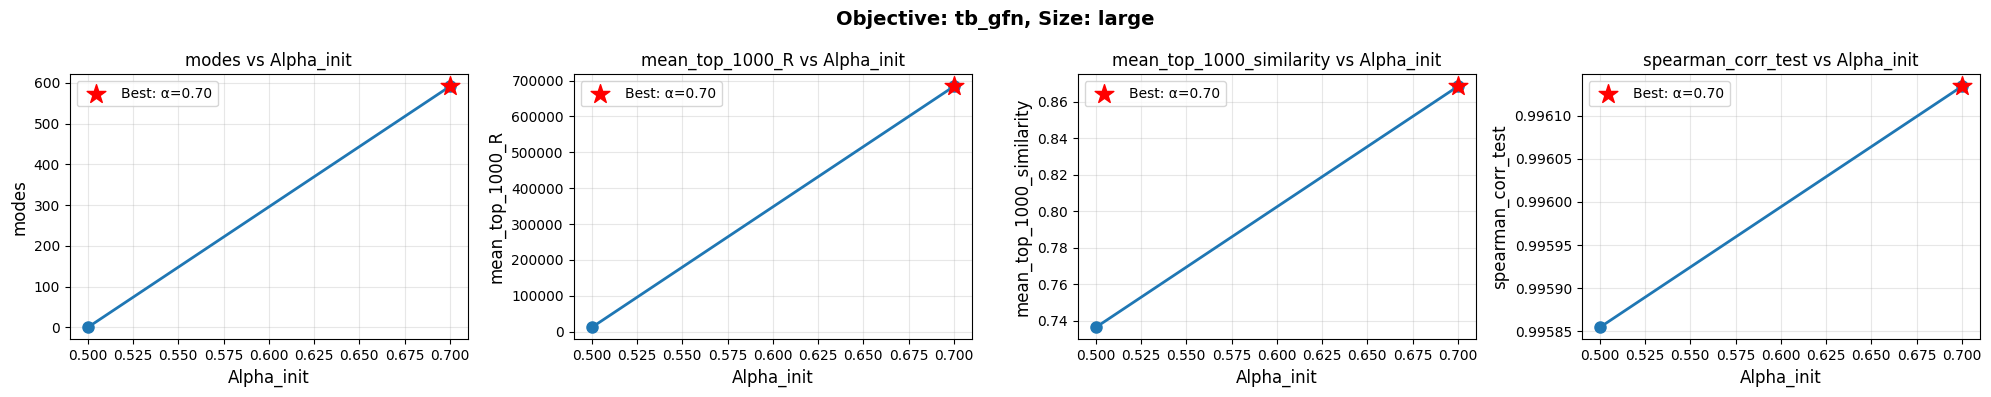

✓ 已保存图表: side_product/set_analysis_tb_gfn_medium.png


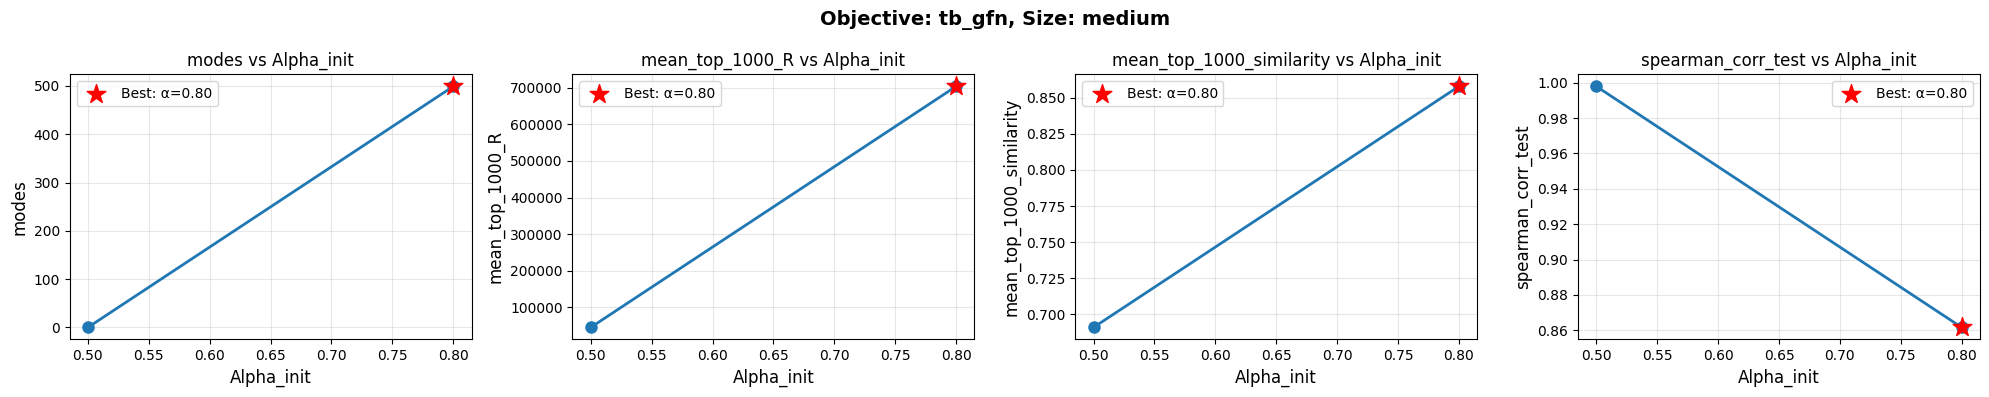

✓ 已保存图表: side_product/set_analysis_tb_gfn_small.png


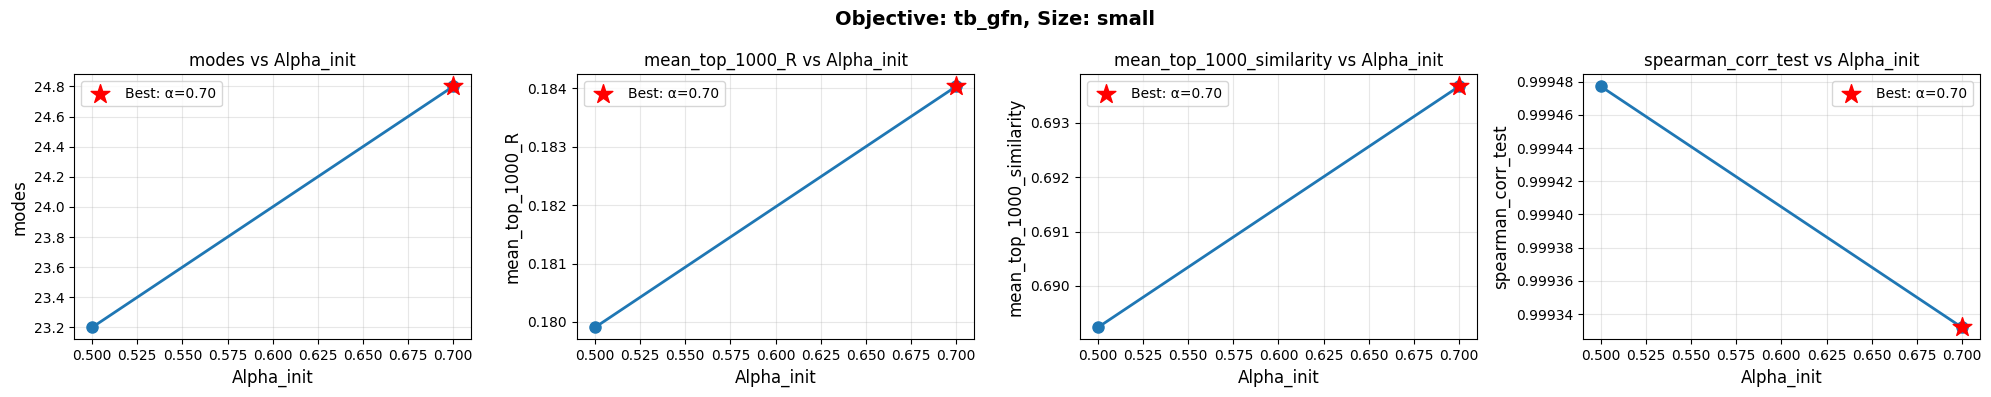


✓ 所有图表生成完毕。


In [3]:
import matplotlib.pyplot as plt

out_dir = Path('side_product')
out_dir.mkdir(exist_ok=True, parents=True)

print(f"\n{'=' * 80}\n生成图表\n{'=' * 80}")
for cfg in fig_configs:
    obj = cfg['method']
    size = cfg['size']
    data = cfg['data']
    metrics_to_plot = cfg['metrics']

    n_metrics = len(metrics_to_plot)
    fig, axes = plt.subplots(1, n_metrics, figsize=(5*n_metrics, 4))
    if n_metrics == 1:
        axes = [axes]

    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx]
        ax.plot(data['alpha'], data[metric], 'o-', linewidth=2, markersize=8)
        
        # 找到最优 alpha 并标注
        if len(data) > 0 and not data[metric].isna().all():
            # 排除 alpha=0.5，选择第二好的；否则选最优的
            sorted_data = data.sort_values(metric, ascending=False)
            candidates = sorted_data[sorted_data['alpha'] != 0.5]
            if len(candidates) > 0:
                best_idx = candidates.index[0]
            else:
                best_idx = data[metric].idxmax()
            
            best_alpha = data.loc[best_idx, 'alpha']
            best_value = data.loc[best_idx, metric]
            
            # 标注最优点（红星）
            ax.scatter([best_alpha], [best_value], color='red', s=200, zorder=5, marker='*', 
                      label=f'Best: α={best_alpha:.2f}')
            
            ax.set_xlabel('Alpha_init', fontsize=12)
            ax.set_ylabel(metric, fontsize=12)
            ax.set_title(f'{metric} vs Alpha_init', fontsize=12)
            ax.grid(True, alpha=0.3)
            ax.legend()

    plt.suptitle(f'Objective: {obj}, Size: {size}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    save_path = out_dir / f"set_analysis_{obj}_{size}.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✓ 已保存图表: {save_path}")
    plt.show()

print("\n" + "=" * 80)
print("✓ 所有图表生成完毕。")
print("=" * 80)

In [4]:
# 记录每个 cfg 对应的最优 alpha（用于筛选）
best_alpha_records = []

fl_subtb_names = {'fl_subtb_gfn', 'fl-subtb', 'fl_subtb'}

for cfg in fig_configs:
    obj = cfg['method']
    size = cfg['size']
    data = cfg['data']
    metrics_to_plot = cfg['metrics']
    
    for metric in metrics_to_plot:
        if len(data) > 0 and not data[metric].isna().all():
            # 使用相同的逻辑查找 best_alpha
            sorted_data = data.sort_values(metric, ascending=False)
            candidates = sorted_data[sorted_data['alpha'] != 0.5]
            if len(candidates) > 0:
                best_idx = candidates.index[0]
            else:
                best_idx = data[metric].idxmax()
            
            best_alpha = data.loc[best_idx, 'alpha']
            if obj in fl_subtb_names:
                best_alpha = 0.6
            best_value = data.loc[best_idx, metric]
            
            best_alpha_records.append({
                'method': obj,
                'size': size,
                'metric': metric,
                'best_alpha': best_alpha,
                'best_value': best_value
            })

# 转换为 DataFrame 并显示
df_best_alphas = pd.DataFrame(best_alpha_records)
print("\n" + "=" * 80)
print("最优 Alpha 汇总")
print("=" * 80)
print(df_best_alphas.to_string(index=False))

# 保存汇总表
best_alpha_csv_path = out_dir / 'best_alphas_summary.csv'
df_best_alphas.to_csv(best_alpha_csv_path, index=False)
print(f"\n✓ 已保存到: {best_alpha_csv_path}")

# 按照 best_alpha 筛选原始数据（保留所有 metric）
print("\n" + "=" * 80)
print("按照 best_alpha 筛选原始数据（保留所有指标）")
print("=" * 80)

best_alpha_data_records = []
# 获取每个 (method, size) 的唯一 best_alpha
for method in df_best_alphas['method'].unique():
    for size in df_best_alphas[df_best_alphas['method'] == method]['size'].unique():
        # 取该 (method, size) 的第一个 best_alpha（假设同一 method-size 的所有 metric 的 best_alpha 相同或取最常见的）
        best_alphas_for_ms = df_best_alphas[(df_best_alphas['method'] == method) & (df_best_alphas['size'] == size)]['best_alpha']
        if len(best_alphas_for_ms) > 0:
            best_alpha = best_alphas_for_ms.iloc[0]  # 取第一个
            if method in fl_subtb_names:
                best_alpha = 0.6
            
            # 从原始数据中筛选出该 method、size、alpha 的所有记录
            mask = (df_all['method'] == method) & (df_all['size'] == size) & (df_all['alpha'] == best_alpha)
            matched_rows = df_all[mask]
            
            if len(matched_rows) > 0:
                # 计算平均和标准差
                record = {
                    'method': method,
                    'size': size,
                    'alpha': best_alpha,
                }
                for m in metrics:
                    record[f'{m}_mean'] = matched_rows[m].mean()
                    record[f'{m}_std'] = matched_rows[m].std()
                best_alpha_data_records.append(record)

df_best_alpha_data = pd.DataFrame(best_alpha_data_records)
print(df_best_alpha_data.to_string(index=False))

best_alpha_data_path = out_dir / 'best_alpha_data.csv'
df_best_alpha_data.to_csv(best_alpha_data_path, index=False)
print(f"\n✓ 已保存到: {best_alpha_data_path}")

# 保存 alpha_init=0.5 的 baseline 数据（包含均值和标准差）
print("\n" + "=" * 80)
print("Baseline 数据 (alpha_init=0.5) 的均值和标准差")
print("=" * 80)

baseline_records = []
for obj in objectives:
    for size in sizes:
        df_obj = df_all[(df_all['method'] == obj) & (df_all['size'] == size) & (df_all['alpha'] == 0.5)].copy()
        if len(df_obj) > 0:
            record = {
                'method': obj,
                'size': size,
                'alpha': 0.5,
            }
            for m in metrics:
                record[f'{m}_mean'] = df_obj[m].mean()
                record[f'{m}_std'] = df_obj[m].std()
            baseline_records.append(record)

df_baseline = pd.DataFrame(baseline_records)
if len(df_baseline) > 0:
    print(df_baseline.to_string(index=False))
    baseline_path = out_dir / 'baseline_alpha0.5_data.csv'
    df_baseline.to_csv(baseline_path, index=False)
    print(f"\n✓ 已保存到: {baseline_path}")
else:
    print("没有找到 alpha=0.5 的数据")


最优 Alpha 汇总
      method   size                   metric  best_alpha    best_value
      db_gfn  large                    modes         0.9    355.800000
      db_gfn  large          mean_top_1000_R         0.9 624721.771862
      db_gfn  large mean_top_1000_similarity         0.9      0.882944
      db_gfn  large       spearman_corr_test         0.9      0.944515
      db_gfn medium                    modes         0.9     31.400000
      db_gfn medium          mean_top_1000_R         0.9 552020.091131
      db_gfn medium mean_top_1000_similarity         0.9      0.803490
      db_gfn medium       spearman_corr_test         0.9      0.972678
      db_gfn  small                    modes         0.9     55.800000
      db_gfn  small          mean_top_1000_R         0.9      0.204380
      db_gfn  small mean_top_1000_similarity         0.9      0.720881
      db_gfn  small       spearman_corr_test         0.9      0.995274
   fl_db_gfn  large                    modes         0.9   2239.

In [5]:
# 合并 best_alpha_data 和 baseline_data
print("\n" + "=" * 80)
print("合并最优 Alpha 和 Baseline 数据")
print("=" * 80)

df_combined = pd.concat([df_best_alpha_data, df_baseline], ignore_index=True)

# 按照 method、size、alpha 排序
df_combined = df_combined.sort_values(['method', 'size', 'alpha']).reset_index(drop=True)

print(df_combined.to_string(index=False))
import os
os.makedirs('results', exist_ok=True)

combined_path = Path('results') / 'data.csv'
df_combined.to_csv(combined_path, index=False)
print(f"\n✓ 已保存到: {combined_path}")


合并最优 Alpha 和 Baseline 数据
      method   size  alpha  modes_mean  modes_std  mean_top_1000_R_mean  mean_top_1000_R_std  mean_top_1000_similarity_mean  mean_top_1000_similarity_std  spearman_corr_test_mean  spearman_corr_test_std
      db_gfn  large    0.5         0.0   0.000000          58086.535407          5216.945176                       0.763214                      0.001974                 0.984226                0.003840
      db_gfn  large    0.9       355.8 319.840116         624721.771862         55336.884563                       0.882944                      0.006609                 0.944515                0.004377
      db_gfn medium    0.5         0.0   0.000000         110427.380192          5337.251186                       0.710264                      0.001300                 0.992868                0.004152
      db_gfn medium    0.9        31.4  34.063177         552020.091131         59210.234237                       0.803490                      0.009403         